# ORAL Cancer detection

This is a computer vision project aimed towards detecting cancerous regions within the oral cavity. You can get the data at :
https://drive.google.com/drive/folders/1oxhFswkETQ598hExXqfULwjV63v6euS_?usp=drive_link

# Code Imports

I used a variety of libraries to test various methods to get this project going. Some of these techniques were picked up from research papers i read through and other were through discussion between me with guidance from my advisor

1. **numpy, pandas**: Libraries for numerical and data manipulation tasks.
2. **seaborn, matplotlib**: Tools for data visualization.
3. **c2, imutils**: Used for image processing with OpenCV.
4. **lightgbm**: Light Gradient Boosting Machine for classification tasks.
5. **skimage**: Functions for image manipulation and feature extraction.
6. **sklearn.ensemble, svm**: Machine learning models like Random Forest and Support Vector Machines.
7. **sklearn.metrics**: Tools for evaluating model performance (accuracy, precision, etc.).
8. **tensorflow, keras**: Libraries for building and training neural networks.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import imutils

import lightgbm as lgb

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

from google.colab.patches import cv2_imshow
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
import PIL
import io
from base64 import b64decode, b64encode
import html
import time
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js


I have all my data on my colab and it can be accessed through the above folder. If you aren't able to access the folder send me an email at : adgkumar@ucdavis.edu


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Image Visualization and Color Space Conversion

In this section, we read an image from the dataset and convert it into various color spaces to explore different representations.

1. **Original Image:**
We read the image using OpenCV and display it using plt.imshow().

2. **RGB Conversion:**
The image is converted from BGR (default OpenCV format) to RGB format, which is commonly used for visualization.

3. **HSV Conversion**:
The image is converted to the HSV (Hue, Saturation, Value) color space, useful for detecting specific colors.

4. **YCrCb Conversion:**
The image is transformed into the YCrCb color space, which separates the luma (Y) and chroma (Cr, Cb) components.

5. **Channel Separation in YCrCb Space**
Y Channel:
The Y (luminance) channel from the YCrCb image is displayed, which represents the intensity of the image.

6. **Cb Channel:**
The Cb (blue-difference chroma) channel is shown, highlighting color differences in the blue region.

7. Cr Channel:
The Cr (red-difference chroma) channel is displayed, focusing on red color intensity.


**Masking and Highlighting White Lesions**
1. White Lesion Mask:

A mask is created using a range of values to isolate potential white lesions in the image (commonly associated with oral cancer). This mask is applied to the image to highlight areas in the white color range.
Masking and Highlighting Red Lesions
2. Red Lesion Mask:

Another mask is generated to detect red lesions by defining upper and lower thresholds in the YCrCb space. This mask is inverted and used to highlight red regions, which can indicate abnormal tissue in oral cancer detection.
#

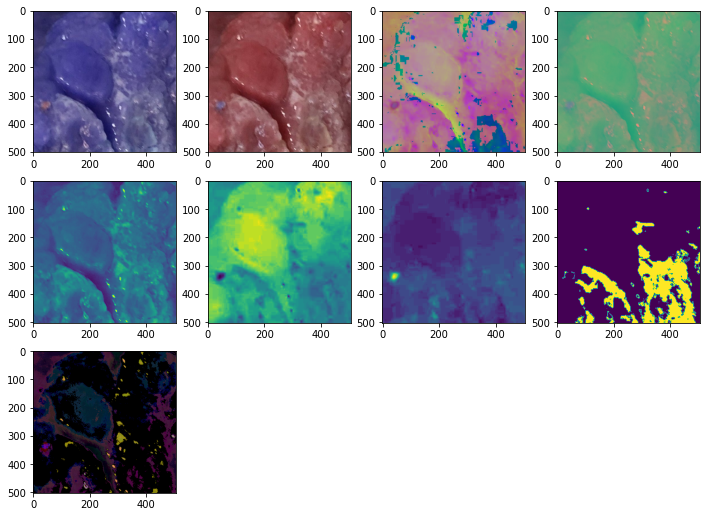

In [ ]:

fig = plt.figure(figsize=(12,12))

row = 4
column = 4

canc_img = cv2.imread('/content/drive/MyDrive/OralCancer/cancer/canc057.jpg')
fig.add_subplot(row , column , 1)
plt.imshow(canc_img)

rgbimg =cv2.cvtColor(canc_img, cv2.COLOR_BGR2RGB)
fig.add_subplot(row , column , 2)
plt.imshow(rgbimg)

hsvimg =cv2.cvtColor(canc_img, cv2.COLOR_BGR2HSV)
fig.add_subplot(row , column , 3)
plt.imshow(hsvimg)

ycrcbimg =cv2.cvtColor(canc_img, cv2.COLOR_BGR2YCR_CB)
fig.add_subplot(row , column , 4)
plt.imshow(ycrcbimg)

yimg = ycrcbimg[:,:,0]
fig.add_subplot(row , column , 5)
plt.imshow(yimg)

cbimg = ycrcbimg[:,:,1]
fig.add_subplot(row , column , 6)
plt.imshow(cbimg)

crimg = ycrcbimg[:,:,2]
fig.add_subplot(row , column , 7)
plt.imshow(crimg)

lower_white = np.array([100, 100, 70], dtype=np.uint8)
upper_white = np.array([225, 155 , 128], dtype=np.uint8)
mask_white = cv2.inRange(ycrcbimg, lower_white, upper_white)
result_white = cv2.bitwise_or(rgbimg,ycrcbimg, mask = mask_white)
fig.add_subplot(row , column ,8)
plt.imshow(mask_white)


lower_red = np.array([90, 90, 70], dtype=np.uint8) # Defining upper limit to determine Red lesions of oral cancer
upper_red = np.array([150, 225 , 128], dtype=np.uint8)
mask_red = cv2.inRange(ycrcbimg, lower_red, upper_red)
mask_red = cv2.bitwise_not(mask_red)

result_red = cv2.bitwise_and(ycrcbimg,rgbimg, mask = mask_red)

fig.add_subplot(row , column ,9)
plt.imshow(result_red)



# Finding and Drawing Contours for White Lesions

The contours of the white lesion mask are detected using cv2.findContours(). This function retrieves the contours from the binary mask image and stores them in a list.
Color Conversion:

The mask is converted from grayscale to RGB format using cv2.cvtColor() for visualization purposes.
Identifying the Largest Contour:

We use max() with cv2.contourArea to identify the largest contour, which represents the most significant white lesion in the mask.
Bounding Rectangle:

A bounding box is created around the largest contour using cv2.boundingRect(). This gives us the coordinates (x, y) and dimensions (w, h) of the rectangle.
Drawing the Rectangle:

The rectangle is drawn around the white lesion using cv2.rectangle() with a green outline (0, 255, 0) to highlight the detected region.
Displaying the Detected Region:

The detected lesion is displayed by cropping the RGB image to the bounding box region (x:x+w, y:y+h) using plt.imshow().


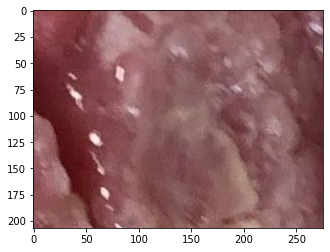

In [ ]:
contours, hierarchy = cv2.findContours(mask_white.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(mask_white, cv2.COLOR_BGR2RGB)
# cv2.drawContours(rgb, contours, -1, (255, 0, 0), 0)

c = max(contours, key = cv2.contourArea)
x,y,w,h = cv2.boundingRect(c)

cv2.rectangle(rgb,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(rgbimg[x:x+w, y:y+h])

# And same things for a Red leison

70552.0


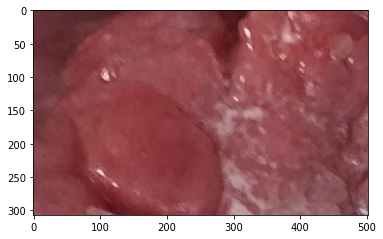

In [ ]:
contours, hierarchy = cv2.findContours(mask_red.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(mask_red, cv2.COLOR_BGR2RGB)
# cv2.drawContours(rgb, contours, -1, (255, 0, 0), 0)


c = max(contours, key = cv2.contourArea)
x,y,w,h = cv2.boundingRect(c)

print(cv2.contourArea(c))


cv2.rectangle(rgb,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(rgbimg[x:x+w, y:y+h])

After testing different lesions, masks, and color schemes I created some script for all the different lessons

In this section, we implement functions that focus on extracting and analyzing lesions without considering their color. The following functions are defined to achieve this:

1. Image Reading and Area Calculation:

The image is read from the specified path using cv2.imread().
The height and width of the image are obtained to calculate the area.
Color Space Conversion:
The image is converted to RGB and YCrCb color spaces to facilitate processing.

2. Mask Creation:

Lower and upper thresholds for detecting red lesions are defined and used to create a mask with cv2.inRange().

3. Contour Detection:

The contours of the masked image are found using cv2.findContours(), and the largest contour is identified.
Bounding Rectangle and Area Filtering:
If a contour is detected, its bounding rectangle is calculated. The lesion area is computed and checked to be between 5% and 60% of the total image area. If it meets the criterion, the lesion image is cropped and returned; otherwise, a zero array is returned.


In [ ]:
#Getting all the Red leisons

def pre_processing_red_leison(path):
  img = cv2.imread(path)  # reading image

  height, width,  _ = img.shape
  area = height*width  #Finding area of Image

  rgbimg= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting image to RGB
  ycrcbimg = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)#Converting image to YCRCB

  lower_red = np.array([90, 90, 70], dtype=np.uint8) # Defining lower limit to determine Red lesions of oral cancer
  upper_red = np.array([150, 225 , 128], dtype=np.uint8) # Defining upper limit to determine Red lesions of oral cancer

  mask_red = cv2.inRange(ycrcbimg, lower_red, upper_red) # creating mask of image using limits ie choosing only those parts of img within defined limits
  mask_red = cv2.bitwise_not(mask_red)

  red_contours, hierarchy = cv2.findContours(mask_red.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) # Finding edges of all determined white lesion parts
  red_c = max(red_contours, key = cv2.contourArea, default = np.array(0)) #Finding largest contour area


  if red_c.any() == True:
    x,y,w,h = cv2.boundingRect(red_c) #Finding edges of largest img
    lesion_area = w*h #Finding area of lesion


    if lesion_area > 0.05 * area  and lesion_area < 0.6*area: # Choosing a lesion only of it it 5-60% of area of image
      lesion_img = rgbimg[x:x+w, y:y+h]
      return (lesion_img)
    else:
      return np.array(0)
  else:
    return np.array(0)

#Getting all the White leisons

def pre_processing_white_leison(path):
  img = cv2.imread(path)  # reading image

  height, width,  _ = img.shape
  area = height*width  #Finding area of Image

  rgbimg= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting image to RGB
  ycrcbimg = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)#Converting image to YCRCB

  lower_white = np.array([100, 100, 70], dtype=np.uint8) # Defining lower limit to determine White lesions of oral cancer
  upper_white = np.array([225, 155 , 128], dtype=np.uint8) # Defining upper limit to determine White lesions of oral cancer

  mask_white = cv2.inRange(ycrcbimg, lower_white, upper_white) # creating mask of image using limits ie choosing only those parts of img within defined limits

  white_contours, hierarchy = cv2.findContours(mask_white.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) # Finding edges of all determined white lesion parts
  white_c = max(white_contours, key = cv2.contourArea, default = np.array(0)) #Finding largest contour area


  if white_c.any() == True:
    x,y,w,h = cv2.boundingRect(white_c) #Finding edges of largest img
    lesion_area = w*h #Finding area of lesion

    if lesion_area > 0.05 * area  and lesion_area < 0.45*area: # Choosing a lesion only of it it 7.5-45% of area of image
      lesion_img = rgbimg[x:x+w, y:y+h]
      return (lesion_img)
    else:
      return np.array(0)
  else:
    return np.array(0)


## Image Upload and Test Train Split

In [ ]:
cancer_leisons = []
cancer_labels = []
grey_leisons = []


for directory_path in glob.glob("/content/drive/MyDrive/OralCancer/cancer/*"):

    label = directory_path.split("/")[-2]

    white_leison = pre_processing_white_leison(directory_path)
    if white_leison.any() !=0:
      white_leison_resize = cv2.resize(white_leison, (64,64))
      grey_img = cv2.cvtColor(white_leison_resize, cv2.COLOR_RGB2GRAY)

      cancer_leisons.append(white_leison_resize)
      cancer_labels.append(label)
      grey_leisons.append(grey_img)


    red_leison = pre_processing_red_leison(directory_path)
    if red_leison.any() !=0:
      red_leison_resize = cv2.resize(red_leison, (64,64))
      grey_img = cv2.cvtColor(red_leison_resize, cv2.COLOR_RGB2GRAY)

      cancer_leisons.append(red_leison_resize)
      cancer_labels.append(label)
      grey_leisons.append(grey_img)




In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/OralCancer/non-cancer/*"):
  label = directory_path.split("/")[-2]
  cancer_labels.append(label)

  img = cv2.imread(directory_path)
  rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  non_cancer = cv2.resize(img, (64,64))
  grey_img = cv2.cvtColor(non_cancer, cv2.COLOR_RGB2GRAY)
  cancer_leisons.append(non_cancer)
  grey_leisons.append(grey_img)


In [ ]:
test_all_images = np.array(cancer_leisons)
test_all_labels = np.array(cancer_labels)
gray_images = np.array(grey_leisons)

train_images,test_images,train_labels,test_labels = train_test_split(gray_images, test_all_labels, test_size = 0.1, random_state = 42)
train_images_2,test_images_2,train_labels_2,test_labels_2 = train_test_split(test_all_images, test_all_labels, test_size = 0.1, random_state = 42)



from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

## Feature Extraction

This code is designed to extract texture features from a dataset of images using the Gray Level Co-occurrence Matrix (GLCM). The extracted features include energy, correlation, dissimilarity, contrast, and homogeneity, which are essential for analyzing the texture properties of the images.

1. Data Structure: The code begins by initializing an empty DataFrame that will hold the extracted features for each image in the dataset.

2. Image Loop: The code iterates over each image in the dataset. For each image, it creates a new DataFrame to store the features specific to that image.

3. GLCM Calculation: The GLCM is computed for various distances and angles. Specifically, the code considers distances of 1, 3, and 5 pixels, and angles of 0, 45, 90, and 135 degrees. This combination allows for a comprehensive analysis of the texture in different orientations and scales.

4. Feature Extraction: For each GLCM calculated, five texture features are extracted:

  a. Energy: Represents the uniformity of the image texture.

  b. Correlation: Measures the degree of linear dependence between pixel pairs.

  c. Dissimilarity: Indicates how different the pixel pairs are.

  d. Contrast: Reflects the intensity contrast between a pixel and its neighbor over the whole image.

  e. Homogeneity: Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.

5. Aggregation: After processing all combinations for a given image, the features are appended to the main DataFrame, which accumulates the features for all images in the dataset.

6. Return Value: Finally, the code returns the complete DataFrame containing the texture features for all images, which can be used for further analysis, classification, or model trainin

In [ ]:
#GLCM FEATURE EXTRACTION
# ENERGY, CORRELATION, DISSIMILARITY, CONSTAST, HOMOGENITY

def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):

        df = pd.DataFrame()
        img = dataset[image, :,:]

        GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

        GLCM = greycomatrix(img, [1], [0])
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr


        GLCM2 = greycomatrix(img, [3], [0])
        GLCM_Energy2 = greycoprops(GLCM2, 'energy')[0]
        df['Energy2'] = GLCM_Energy2
        GLCM_corr2 = greycoprops(GLCM2, 'correlation')[0]
        df['Corr2'] = GLCM_corr2
        GLCM_diss2 = greycoprops(GLCM2, 'dissimilarity')[0]
        df['Diss_sim2'] = GLCM_diss2
        GLCM_hom2 = greycoprops(GLCM2, 'homogeneity')[0]
        df['Homogen2'] = GLCM_hom2
        GLCM_contr2 = greycoprops(GLCM2, 'contrast')[0]
        df['Contrast2'] = GLCM_contr2

        GLCM3 = greycomatrix(img, [5], [0])
        GLCM_Energy3 = greycoprops(GLCM3, 'energy')[0]
        df['Energy3'] = GLCM_Energy3
        GLCM_corr3 = greycoprops(GLCM3, 'correlation')[0]
        df['Corr3'] = GLCM_corr3
        GLCM_diss3 = greycoprops(GLCM3, 'dissimilarity')[0]
        df['Diss_sim3'] = GLCM_diss3
        GLCM_hom3 = greycoprops(GLCM3, 'homogeneity')[0]
        df['Homogen3'] = GLCM_hom3
        GLCM_contr3 = greycoprops(GLCM3, 'contrast')[0]
        df['Contrast3'] = GLCM_contr3

        GLCM4 = greycomatrix(img, [0], [np.pi/4])
        GLCM_Energy4 = greycoprops(GLCM4, 'energy')[0]
        df['Energy4'] = GLCM_Energy4
        GLCM_corr4 = greycoprops(GLCM4, 'correlation')[0]
        df['Corr4'] = GLCM_corr4
        GLCM_diss4 = greycoprops(GLCM4, 'dissimilarity')[0]
        df['Diss_sim4'] = GLCM_diss4
        GLCM_hom4 = greycoprops(GLCM4, 'homogeneity')[0]
        df['Homogen4'] = GLCM_hom4
        GLCM_contr4 = greycoprops(GLCM4, 'contrast')[0]
        df['Contrast4'] = GLCM_contr4

        GLCM5 = greycomatrix(img, [0], [np.pi/2])
        GLCM_Energy5 = greycoprops(GLCM5, 'energy')[0]
        df['Energy5'] = GLCM_Energy5
        GLCM_corr5 = greycoprops(GLCM5, 'correlation')[0]
        df['Corr5'] = GLCM_corr5
        GLCM_diss5 = greycoprops(GLCM5, 'dissimilarity')[0]
        df['Diss_sim5'] = GLCM_diss5
        GLCM_hom5 = greycoprops(GLCM5, 'homogeneity')[0]
        df['Homogen5'] = GLCM_hom5
        GLCM_contr5 = greycoprops(GLCM5, 'contrast')[0]
        df['Contrast5'] = GLCM_contr5

        image_dataset = image_dataset.append(df)

    return image_dataset

In [ ]:
image_features = feature_extractor(train_images)
print(image_features)

      Energy      Corr   Diss_sim   Homogen    Contrast   Energy2     Corr2  \
0   0.027130  0.948653  10.551339  0.150591  305.599454  0.022750  0.836383   
0   0.020655  0.901485  12.849454  0.100118  366.567708  0.018718  0.643371   
0   0.029036  0.932887   6.229415  0.192258  104.213542  0.024037  0.805985   
0   0.024925  0.917029   8.792163  0.152274  203.565972  0.020299  0.575039   
0   0.024610  0.909909   9.740079  0.156033  270.398810  0.021550  0.694812   
..       ...       ...        ...       ...         ...       ...       ...   
0   0.029766  0.947439   5.741567  0.164780   53.872024  0.025996  0.849291   
0   0.022167  0.724848  14.218254  0.076085  361.581845  0.021735  0.578925   
0   0.030590  0.681505   8.888641  0.132008  162.562748  0.028334  0.415236   
0   0.038114  0.979995   8.057292  0.175040  125.827629  0.034870  0.967182   
0   0.021792  0.948638   9.672371  0.136240  219.644097  0.020392  0.893565   

    Diss_sim2  Homogen2    Contrast2  ...   Energy4

In [ ]:
#Mean values of rgb hsv red blue green hue saturation variance

def color_features_2(dataset):
  data = []

  for image in range(dataset.shape[0]):
        img = dataset[image, :,:]
        img_mean = np.mean(img, axis = (0,1))
        red_mean = img_mean[0]
        blue_mean = img_mean[1]
        # df['Blue_Mean'] = blue_mean

        green_mean = img_mean[2]
        # df['Green_Mean'] = blue_mean

        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_mean = np.mean(hsv_img, axis = (0,1))

        hue_mean = hsv_mean[0]
        # df['Hue_Mean'] = hue_mean

        saturation_mean = hsv_mean[1]
        # df['Saturation_Mean'] = saturation_mean

        rgb_deviation = np.std(img)
        # df['RGB_deviation'] = rgb_deviation

        green_deviation = np.std(img[:,:,2])
        # df['Green_deviation'] = green_deviation

        hue_deviation = np.std(hsv_img[:,:,0])
        # df['Hue_deviation'] = hue_deviation

        saturation_deviation = np.std(hsv_img[:,:,1])
        # df['Saturation_deviation'] = saturation_deviation

        ycrcbimg =cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

        blue_diff_deviation = np.std(ycrcbimg[:,:,1])
        # df['Blue_chroma_deviation'] = blue_diff_deviation

        red_diff_deviation = np.std(ycrcbimg[:,:,2])
        # df['Red_chroma_deviation'] = red_diff_deviation

        img_values = [red_mean, blue_mean, hue_mean, saturation_mean, rgb_deviation, green_deviation, hue_deviation, saturation_deviation, blue_diff_deviation, red_diff_deviation]

        data.append(img_values)


  color_dataset = pd.DataFrame(data, columns=['Red_Mean', 'Blue_Mean', 'Hue_Mean', 'Saturation_Mean', 'RGB_deviation', 'Green_deviation', 'Hue_deviation', 'Saturation_deviation', 'Blue_chroma_deviation', 'Red_chroma_deviation'])

  return color_dataset


In [ ]:
color_features = color_features_2(train_images_2)


In [ ]:
print(color_features)

     Red_Mean  Blue_Mean  Hue_Mean  Saturation_Mean  RGB_deviation  \
0    107.6035   111.8230  116.5583          96.6995        58.4875   
1     85.0720   101.0237  113.2498         125.6536        55.0249   
2     79.2456    73.7844  121.1165         139.8784        48.9324   
3    185.8040   128.9756   51.8735          93.2695        47.6749   
4    117.1526   106.3657  123.6484         122.2261        60.3817   
..        ...        ...       ...              ...            ...   
136  140.1216    83.9617  111.5752         105.9087        34.3470   
137  121.1951   118.9231  120.6494         119.6155        53.1378   
138  166.3003   103.4722  159.3433          97.1702        33.0213   
139  140.6846   135.7134  122.4668          83.1228        66.3202   
140  122.0044   122.7837  120.4749         117.8613        61.6521   

     Green_deviation  Hue_deviation  Saturation_deviation  \
0            45.9542        17.3662               38.5056   
1            50.8289         4.2849  

In [ ]:
df2 = pd.merge(image_features, color_features, left_index=True, right_index=True)


In [ ]:
from sklearn import svm
svc = svm.SVC(decision_function_shape='ovo')
svc.fit(df2, y_train)


test_features = feature_extractor(x_test)
test_color = color_features_2(test_images_2)
# test_features = np.expand_dims(test_features, axis=0)
df_test = pd.merge(test_features, test_color, left_index=True, right_index=True)

test_svm = np.reshape(df_test, (x_test.shape[0], -1))

test_pred = svc.predict(test_svm)
print(test_pred)
print(y_test)

accuracy = accuracy_score(y_test, test_pred )
print(accuracy)

conf = confusion_matrix(y_test, test_pred)
print(conf)

[0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0]
[1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
0.625
[[7 1]
 [5 3]]


In [ ]:
print(df2.shape)

(141, 35)


## Image Augmentation

I tried a variety of segmentation and augmentation to try to expand the pool of images

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
import pandas as pd
import numpy as np

## Dummy data
X_train = df2

model = Sequential()
# model.add(Reshape((1,X_train.shape[1],1)))

model.add(Conv2D(filters = 32, kernel_size = (1,5),padding = 'Same',
             activation ='relu', input_shape = (141,35)))

model.add(MaxPooling2D(pool_size = (1,6), strides=(1,2)))

model.add(Flatten())

model.add(Dense (500, activation='relu'))
model.add(Dense (1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
## Training and testing with dummy data just to prove that it's working
model.fit(np.array(X_train), y_train, epochs=25)


ValueError: ignored

In [ ]:
def roi(img, centre_list):

  images = []
  height = img.shape[0]
  width = img.shape[1]

  for i in range(int(len(centre_list)/2)):
      x = centre_list[i] - int(width/4)
      y= centre_list[i+1] - int(height/4)
      cropped_img = img[y:y+int(height/2),x:x+int(width/2)]
      cropped_img = cv2.resize(cropped_img, (256,256))

      images.append((cropped_img))

  return images

In [ ]:
def img_rotate(img):

  images2 = []
  (rows, cols) = img.shape[:2]
  center = (cols / 2, rows / 2)
  matrix = cv2.getRotationMatrix2D(center, -15, 1)
  rotated_img = cv2.warpAffine(img, matrix, (cols, rows))
  images2.append(rotated_img)

  matrix2 = cv2.getRotationMatrix2D(center, 15, 1)
  rotated_img2 = cv2.warpAffine(img, matrix2, (cols, rows))
  images2.append(rotated_img2)

  return images2





In [ ]:
     def multi_centre(img):

  centre_list = []
  centre = 4
  (rows, cols) = img.shape[:2]
  width_area = int(rows/13)
  height_area = int(rows/13)

  for i in range(4):
    random_y = random.randint(0,height_area)
    random_x = random.randint(0,width_area)

    new_x = int(6*rows/13)
    new_y = int(6*cols/13)+random_y

    centre_list.append(new_x)
    centre_list.append(new_y)

  return centre_list



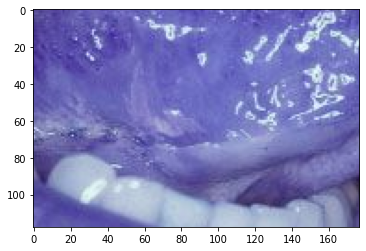

In [ ]:
cancer = []
img_labels = []

for directory_path in glob.glob("/content/drive/MyDrive/Complete_Img/*"):

    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):


      canc_img = cv2.imread(img_path)
      grey_img = cv2.cvtColor(canc_img, cv2.COLOR_BGR2GRAY)
      img2 = cv2.resize(grey_img, (256,256))
      canc_img = np.array(img2)

      rotated_img = img_rotate(canc_img)
      for i in rotated_img:
        cancer.append(i)
        if label == 'cancer (1)':
          img_labels.append(0)
        else:
          img_labels.append(1)

      centre_list = multi_centre(canc_img)
      region_interest = roi(canc_img, centre_list)
      for j in region_interest:
        cancer.append(j)
        if label == 'cancer (1)':
          img_labels.append(0)
        else:
          img_labels.append(1)




cancer (1)
non-cancer


In [ ]:
npcancer_images = np.array(cancer)
npcancer_labels = np.array(img_labels)

In [ ]:
import keras
x_train,x_test,y_train,y_test = train_test_split(npcancer_images, npcancer_labels, test_size = 0.15)

train_data = x_train.astype(np.float32)/255
test_data = x_test.astype(np.float32)/255

train_data = np.expand_dims(train_data,-1)
test_data = np.expand_dims(test_data,-1)

train_labels = keras.utils.to_categorical(y_train)
test_labels = keras.utils.to_categorical(y_test)

## CNN

Model Initialization: You start by creating a sequential model, allowing you to stack layers in order.

Convolutional Layers:

The model has multiple convolutional layers, with increasing numbers of filters (32, 64, and 128) to extract features from the input images.
Each convolutional layer uses a (3, 3) kernel size and ReLU activation function to introduce non-linearity.
Max pooling layers follow each convolutional layer to downsample the feature maps, reducing their size while retaining important information.
Dropout Layers: Two dropout layers (with a rate of 0.25) are included to help prevent overfitting by randomly dropping some neurons during training.

Flattening: The output from the convolutional layers is flattened into a 1D vector to prepare for the fully connected layers.

Dense Layers: A dense layer with 64 units and ReLU activation processes the flattened features, followed by another dropout layer. The final output layer has 2 units with a sigmoid activation function for binary classification.

Compilation: The model is compiled using the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.



In [ ]:
model = Sequential()

# Layer 1
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

#Layer 2
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))

#Layer 3
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
model.fit(train_data, train_labels,epochs=20, validation_split=0.25)


Epoch 1/20
21/21 [==============================] - 59s 3s/step - loss: 0.7162 - accuracy: 0.5938 - val_loss: 0.6495 - val_accuracy: 0.6667
Epoch 2/20
21/21 [==============================] - 53s 3s/step - loss: 0.6571 - accuracy: 0.6473 - val_loss: 0.6430 - val_accuracy: 0.6667
Epoch 3/20
21/21 [==============================] - 54s 3s/step - loss: 0.6579 - accuracy: 0.6473 - val_loss: 0.6596 - val_accuracy: 0.6667
Epoch 4/20
21/21 [==============================] - 53s 3s/step - loss: 0.6587 - accuracy: 0.6473 - val_loss: 0.6568 - val_accuracy: 0.6667
Epoch 5/20
21/21 [==============================] - 53s 3s/step - loss: 0.6591 - accuracy: 0.6443 - val_loss: 0.6521 - val_accuracy: 0.6667
Epoch 6/20
21/21 [==============================] - 54s 3s/step - loss: 0.6456 - accuracy: 0.6473 - val_loss: 0.6309 - val_accuracy: 0.6667
Epoch 7/20
21/21 [==============================] - 53s 3s/step - loss: 0.6373 - accuracy: 0.6592 - val_loss: 0.6388 - val_accuracy: 0.6667
Epoch 8/20
21/21 [==

In [ ]:
results = model.evaluate(test_data, test_labels)

predictions = model.predict(x_test)
pred_labels = np.argmax(predictions, axis = 1)


test_label = np.argmax(test_labels, axis = 1)

print(pred_labels)
print(test_label)

5/5 [==============================] - 3s 565ms/step
[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1]
[1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1
 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0
 1 0 0 0 1 1 1 1 1 0 0]


In [ ]:
tf.math.confusion_matrix(
    test_label,
    pred_labels,
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[56,  4],
       [78, 21]], dtype=int32)>

## CNN 2

In [ ]:
cancer2 = []
img_labels2 = []

for directory_path in glob.glob("/content/drive/MyDrive/Complete_Img/*"):

    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):


      canc_img = cv2.imread(img_path)
      grey_img = cv2.cvtColor(canc_img, cv2.COLOR_BGR2GRAY)
      img2 = cv2.resize(grey_img, (256,256))
      canc_img = np.array(img2)

      rotated_img = img_rotate(canc_img)
      for i in rotated_img:
        cancer2.append(i)
        if label == 'cancer (1)':
          img_labels2.append(0)
        else:
          img_labels2.append(1)

      x = canc_img.shape [1]
      y= canc_img.shape [0]
      cropped_img = canc_img[y-int(y/4):y+int(y/4),x-int(x/4):x+int(x/4)]
      cropped_img = cv2.resize(cropped_img, (256,256))

      cancer2.append(j)
      if label == 'cancer (1)':
          img_labels2.append(0)
      else:
          img_labels2.append(1)

cancer (1)
non-cancer


In [ ]:
npcancer_images2 = np.array(cancer2)
npcancer_labels2 = np.array(img_labels2)

In [ ]:
import keras
x_train2,x_test2,y_train2,y_test2 = train_test_split(npcancer_images2, npcancer_labels2, test_size = 0.15)

train_data2 = x_train2.astype(np.float32)/255
test_data2 = x_test2.astype(np.float32)/255

train_data2 = np.expand_dims(train_data2,-1)
test_data2 = np.expand_dims(test_data2,-1)

train_labels2 = keras.utils.to_categorical(y_train2)
test_labels2 = keras.utils.to_categorical(y_test2)

In [ ]:
model.fit(train_data2, train_labels2,epochs=20, validation_split=0.25)


Epoch 1/20
11/11 [==============================] - 39s 4s/step - loss: 0.6394 - accuracy: 0.7113 - val_loss: 0.5689 - val_accuracy: 0.6875
Epoch 2/20
11/11 [==============================] - 26s 2s/step - loss: 0.5254 - accuracy: 0.6607 - val_loss: 0.5543 - val_accuracy: 0.6696
Epoch 3/20
11/11 [==============================] - 26s 2s/step - loss: 0.4800 - accuracy: 0.7143 - val_loss: 0.4911 - val_accuracy: 0.7768
Epoch 4/20
11/11 [==============================] - 26s 2s/step - loss: 0.4116 - accuracy: 0.7946 - val_loss: 0.4534 - val_accuracy: 0.8125
Epoch 5/20
11/11 [==============================] - 27s 2s/step - loss: 0.3884 - accuracy: 0.8214 - val_loss: 0.5181 - val_accuracy: 0.7679
Epoch 6/20
11/11 [==============================] - 29s 3s/step - loss: 0.3799 - accuracy: 0.8065 - val_loss: 0.4238 - val_accuracy: 0.7946
Epoch 7/20
11/11 [==============================] - 26s 2s/step - loss: 0.3572 - accuracy: 0.8185 - val_loss: 0.4007 - val_accuracy: 0.8125
Epoch 8/20
11/11 [==

In [ ]:
results2 = model.evaluate(test_data2, test_labels2)

predictions2 = model.predict(x_test2)
pred_labels2 = np.argmax(predictions2, axis = 1)


test_label2 = np.argmax(test_labels2, axis = 1)

print(pred_labels2)
print(test_label2)

tf.math.confusion_matrix(
    test_label2,
    pred_labels2,
)

3/3 [==============================] - 1s 419ms/step
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0
 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0
 0 1 1 0 0 0]
[1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1
 0 1 1 1 1 0]


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[15, 12],
       [12, 41]], dtype=int32)>

## Random Forest

Code Overview
Data Preparation:

Converts the cancer and img_labels lists into NumPy arrays for easier manipulation.
Data Splitting:

Splits the data into training (85%) and testing (15%) sets using train_test_split.
Flattening Images:

Reshapes the images into a 2D format suitable for traditional machine learning models.
Random Forest Classifier:

Initializes and trains a Random Forest model with 50 trees and a maximum depth of 10, then makes predictions on the test set.
Decision Tree Classifier:

Creates and trains a Decision Tree model with a maximum depth of 10, followed by predictions on the test data.
Generating Reports:

Produces classification reports for both models, detailing metrics like precision and recall for "Cancerous" and "Non-Cancerous" classes.


In [ ]:
# Convert lists to numpy arrays
images = np.array(cancer)
labels = np.array(img_labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

# Flatten the images for use in traditional machine learning models
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# --- Random Forest Classifier ---
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(x_train_flat, y_train)

# Predictions for Random Forest
y_pred_rf = rf_model.predict(x_test_flat)

# --- Decision Tree Classifier (with limited depth) ---
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(x_train_flat, y_train)

# Predictions for Decision Tree
y_pred_dt = dt_model.predict(x_test_flat)

# Generate classification reports
rf_report = classification_report(y_test, y_pred_rf, target_names=["Cancerous", "Non-Cancerous"])
dt_report = classification_report(y_test, y_pred_dt, target_names=["Cancerous", "Non-Cancerous"])

print("Random Forest Classification Report:\n", rf_report)
print("Decision Tree Classification Report:\n", dt_report)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Create and train the model
svm_model = svm.SVC(kernel='linear') # You can experiment with other kernels like 'rbf'
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


# RNN

Model Initialization:

Creates a Sequential model to stack layers sequentially.
CNN Feature Extraction:

Adds TimeDistributed layers for convolutional operations, allowing the model to process sequences of images.
Conv2D Layer: Extracts features from 64x64 grayscale images with 32 filters.
MaxPooling2D Layer: Reduces the spatial dimensions of the feature maps.
Flatten Layer: Converts the pooled feature maps into a 1D array for input into the LSTM.
RNN Layer:

Adds an LSTM layer with 100 units to capture temporal dependencies from the sequential data.
Output Layer:

A Dense layer with a sigmoid activation function for binary classification.
Model Compilation:

Compiles the model using the Adam optimizer and binary cross-entropy loss, tracking accuracy as a metric.
Model Training:

Trains the model using the training dataset for 10 epochs with a batch size of 32, validating against a test set.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed

model = Sequential()

# CNN layers to extract features
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 64, 64, 1)))  # Adjust input shape accordingly
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))

# RNN layer (LSTM)
model.add(LSTM(100, return_sequences=False))

# Fully connected layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (use your dataset)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
